<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [1]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time


In [3]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: []
Userai: cpu


Collegamento al drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [5]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [ ]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [6]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
DURATION = 5.0       # lunghezza standard (secondi)
BATCH_SIZE = 32

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9

In [8]:
def load_audio_file(file_path, sr=44100, duration=5.0, top_db = 30):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    y, _ = librosa.effects.trim(y, top_db=top_db)           # elimina silence iniziale e finale
    y = librosa.util.normalize(y)           # normalizzazione RMS
    #if len(y) < int(sr * duration):
    #    padding = int(sr * duration) - len(y)
    #    y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

In [9]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [05:00<00:00, 30.10s/it]


In [ ]:
#X_audio = np.array(X_audio)
#y_labels = np.array(y_labels)

#print("Shape X:", X_audio.shape)
#print("Shape y:", y_labels.shape)

Shape X: (400, 220500)
Shape y: (400,)


In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.3, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 280, Val: 60, Test: 60


## NAA

tolgo il silenzio? su esc10 si su esc50 no ?
metto noise injection?
noise = np.random.normal(0, 0.005, y.shape)
  y_noisy = y + noise
  augmented.append(y_noisy)

In [11]:
# def naa(y, sr):
#   augmented = []
#   augmented.append(y)
#   #PPS
#   augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2))
#   #NPS
#   augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2))
#   #Slow Time Stretching
#   augmented.append(librosa.effects.time_stretch(y, rate=0.7))
#   #Fast Time Streatching
#   augmented.append(librosa.effects.time_stretch(y, rate=1.2))
#   return augmented

In [22]:
def center_crop(y, sr, max_duration=5.0):
    max_len = int(sr * max_duration)
    if len(y) <= max_len:
        return y
    start = (len(y) - max_len) // 2
    return y[start:start + max_len]

In [23]:
def naa(y, sr):
    augmented = []
    augmented.append(y)
    # Pitch Shift
    augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2))
    augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2))
    # Time Stretching
    for rate in [0.7, 1.2]:
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        y_stretched = center_crop(y_stretched, sr, max_duration=5.0)
        augmented.append(y_stretched)
    return augmented

In [24]:
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))


NAA: 100%|██████████| 280/280 [01:55<00:00,  2.41it/s]


In [25]:
# Calcola le lunghezze di tutti gli audio
lengths = [len(x) for x in X_train_aug]

# Trova il minimo e il massimo
min_len = min(lengths)
max_len = max(lengths)

# Converti in secondi (facoltativo)
min_sec = min_len / SAMPLE_RATE
max_sec = max_len / SAMPLE_RATE

print(f"Audio più corto: {min_len} samples ({min_sec:.2f} s)")
print(f"Audio più lungo: {max_len} samples ({max_sec:.2f} s)")


Audio più corto: 10667 samples (0.24 s)
Audio più lungo: 220500 samples (5.00 s)


## Converti in log-Mel

In [27]:
def preprocess_audio(y, sr=44100, n_mels=64, n_fft=1024, hop_length=512):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


In [28]:
def batch_logmel(X, sr=44100):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        mel_list.append(mel)
    return mel_list


In [29]:
X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

Log-Mel: 100%|██████████| 60/60 [00:00<00:00, 99.33it/s]


In [30]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 1400
Val set: 60
Test set: 60
Shape primo sample train: (64, 317)


visualizzo logmel spect

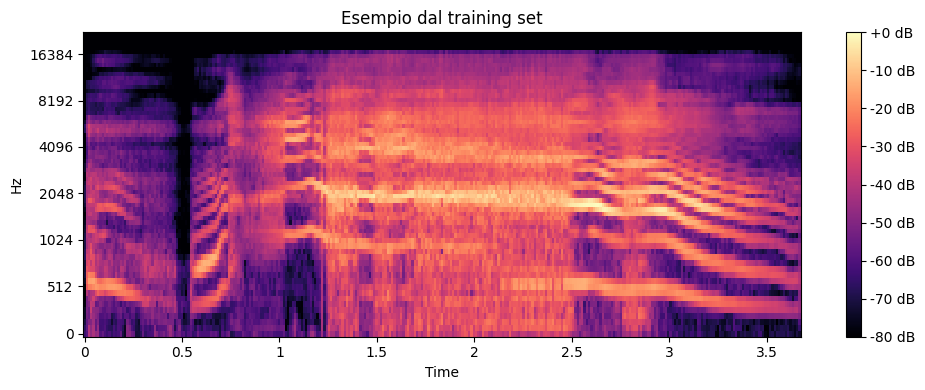

Class:  3


In [31]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
show_mel(X_train_mel[0], title="Esempio dal training set")
print("Class: ", y_train_aug[0])


In [32]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding per uniformare le lunghezze

In [33]:
max_len = max([mel.shape[1] for mel in X_train_mel])
def pad_mel(mel, max_len):
    if mel.shape[1] < max_len:
        pad_width = max_len - mel.shape[1]
        return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
    else:
        return mel[:, :max_len]
X_train_mel = [pad_mel(mel, max_len) for mel in X_train_mel]
X_val_mel = [pad_mel(mel, max_len) for mel in X_val_mel]
X_test_mel = [pad_mel(mel, max_len) for mel in X_test_mel]


## DATA AUG TAA

In [34]:
taa_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    brightness_range=[0.5, 1.5],
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [35]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

y_train_np = np.array(y_train_aug)  # Etichette corrispondenti

Normalizzazione

In [36]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

TAA

In [44]:
X_taa = []
y_taa = []

augmentations_per_sample = 1  # puoi aumentare questo numero

for i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):
    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)
    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)

    # Genera augmentazioni
    gen = taa_generator.flow(sample, batch_size=1)
    for _ in range(augmentations_per_sample):
        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)
        X_taa.append(aug_sample)
        y_taa.append(y_train_np[i])

# Combina con il training set originale
X_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)
y_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)

print("Nuova shape X:", X_train_augmented.shape)
print("Nuova shape y:", y_train_augmented.shape)

TAA Augmentation: 100%|██████████| 1400/1400 [00:08<00:00, 171.15it/s]


Nuova shape X: (2800, 64, 431, 1)
Nuova shape y: (2800,)


Converto in tensori

In [45]:
X_train = torch.from_numpy(X_train_augmented).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_augmented).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [46]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([2800, 64, 431, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


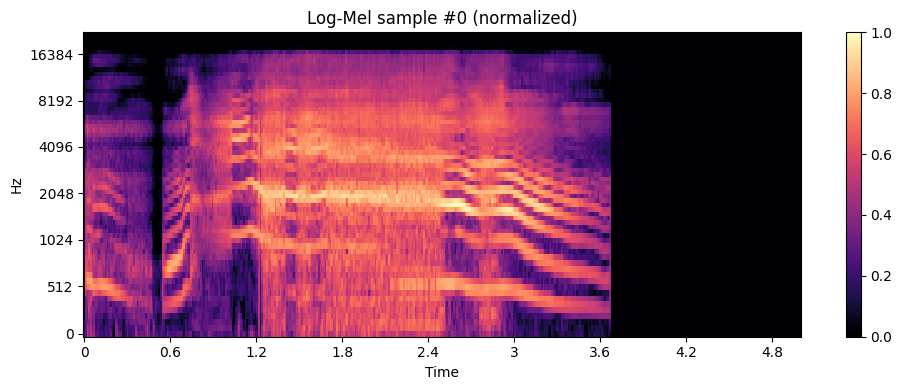

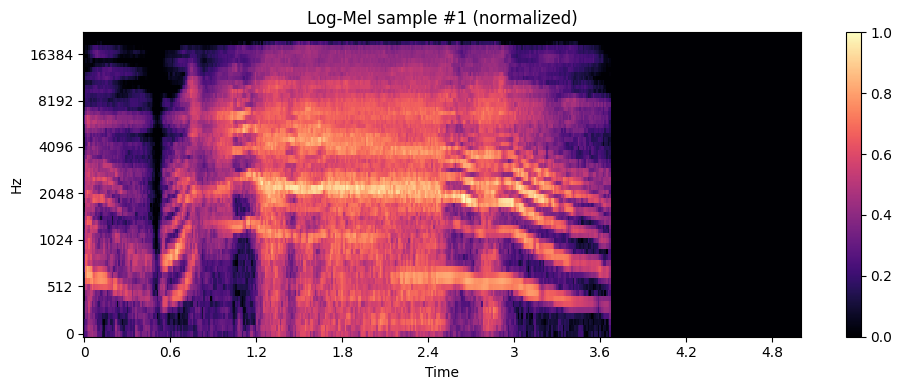

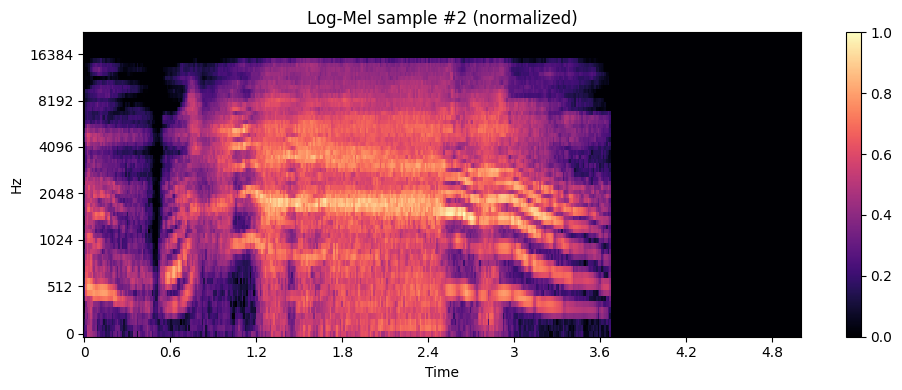

In [47]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()

for i in range(3):
    show_mel_sample(i)

In [48]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([2800])
Etichette uniche: [0 1 2 3 4 5 6 7 8 9]
Esempio 0: label = 3
Esempio 1: label = 3
Esempio 2: label = 3


# Spike Encoding

We define now an helper function to visualize the following ecoded spike trains.

In [ ]:
def visualize_spike_trains(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0].squeeze(-1)[sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels]
        if len(spike_tensor.shape) == 3:
            spikes = spike_tensor.squeeze(-1)[sample_idx, :, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()

## Delta Modulation

Delta modulation converts time-series tensors into spike trains by looking at the difference between pair of subsequent values.

By default, if the difference is both *positive* and *greater than a predefined threshold* $V_{\text{thr}}$, a spike is generated.
However, this type of encoding does not account for large negative peaks in the signal, leading to a possible loss of information in the encoding. For this reason, we consider also negative spikes (or *off-spikes*), that are generated when the difference between subsequent values is both *negative* and *greater than the threshold* $V_{\text{thr}}$ *in absolute value*.

Mathematically, given an input sequence $x[t], t=1,\dots,T$, where $T$ denotes the number of time steps, and a *positive* threshold $V_{\text{thr}}$, the spike encoding with delta modulation is obtained as:
$$
S[t] =
\begin{cases}
\, 1 \qquad \text{if}\;\; x[t+1]-x[t] > V_{\text{thr}}\\
-1 \;\,\quad \text{if}\;\; x[t+1]-x[t] < -V_{\text{thr}}\\
\, 0 \qquad \text{otherwise.}
\end{cases}
$$



Due to the high dimensionality of the input data, feeding it directly into the model significantly slows down training. To mitigate this, I implemented an aggregation process within the \_\_getitem\_\_() function. This process divides the spectrogram along the time axis into fixed-size chunks and computes the mean across the time frames within each chunk, effectively reducing the temporal resolution and improving training efficiency.



In [ ]:
class DeltaAudioDataset(Dataset):
  def __init__(self, X, y, threshold=0.05, timesteps=10, off_spike=True):
    """
    X: Tensor of shape [num_samples, n_mels, time_steps, 1]
    y: Tensor of shape [num_samples]
    """
    self.X = X
    self.y = y
    self.timesteps = timesteps
    self.threshold = threshold
    self.off_spike = off_spike

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1) # [n_mels, time_steps]
    y = self.y[idx]

    chunk_len = x.shape[-1] // self.timesteps
    chunks = []
    for t in range(self.timesteps):
      window = x[:, t * chunk_len: (t + 1) * chunk_len]
      chunk = window.mean(dim=-1)
      chunks.append(chunk)

    x_chunks = torch.stack(chunks, dim=0)

    # Apply delta modulation (shape stays [time_steps, n_mels])
    spike_train = spikegen.delta(
        x_chunks,
        threshold=self.threshold,
        off_spike=self.off_spike
    )

    return spike_train, y.long()

In [ ]:
# Datasets
train_dataset = DeltaAudioDataset(
    X_train,
    y_train,
    threshold=0.1,
    timesteps=50
)
val_dataset = DeltaAudioDataset(
    X_val,
    y_val,
    threshold=0.1,
    timesteps=50
)
test_dataset = DeltaAudioDataset(
    X_test,
    y_test,
    threshold=0.1,
    timesteps=50
)

# Data Loaders
delta_train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)
delta_val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)
delta_test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)

X_batch, y_batch = next(iter(delta_train_dataloader))
print(X_batch.shape)

torch.Size([32, 50, 64])


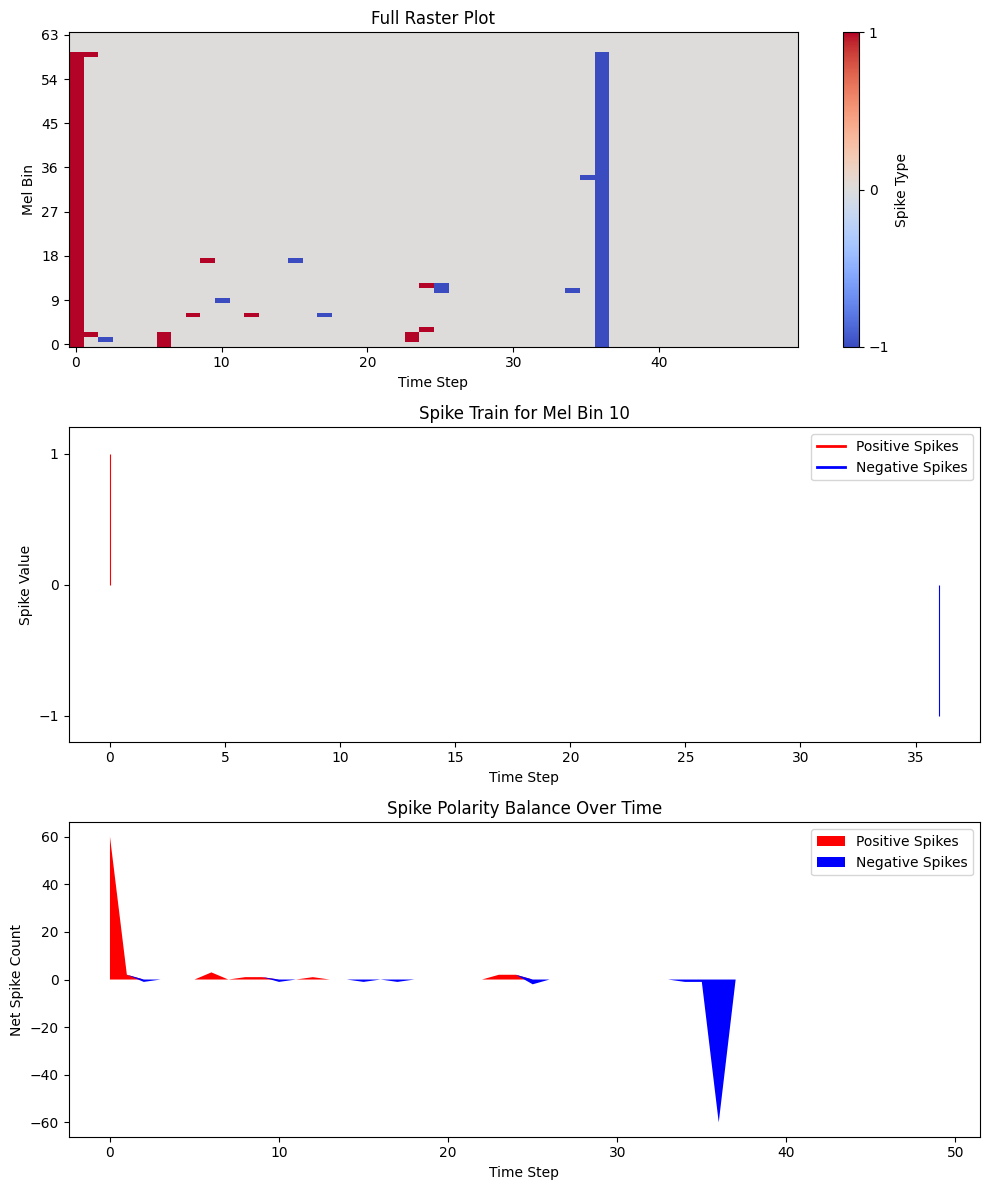

Class chainsaw


In [ ]:
sample_idx = 0
visualize_spike_trains(X_batch, sample_idx=sample_idx, mel_bin=10)
print("Class", ESCLabels(y_batch[sample_idx].item()).name)

## Moving Window

In [ ]:
class MovingWindowDataset(Dataset):
  def __init__(self, X, y, window_length=10):
    """
      Moving Window encoding dataset for audio spectrograms.

      Args:
          X: Tensor of shape [num_samples, n_mels, time_steps, 1]
          y: Tensor of labels [num_samples]
          window_length: Size of the sliding window for calculating the base mean
    """
    self.X = X
    self.y = y
    self.window_length = window_length

  def __len__(self):
    return len(self.X)

  def _encode(self, signal):
    """
      Encode a signal using the Moving Window algorithm.

      Args:
          signal: 1D tensor to encode

      Returns:
          Encoded spike train with values {-1, 0, 1}
    """
    signal_np = signal.numpy()

    # Calculate variation and threshold
    variation = np.diff(signal_np, prepend=signal_np[0])
    threshold = np.mean(np.abs(variation))

    # Initialize spike array
    spikes = np.zeros_like(signal_np, dtype=np.int8)

    # Compute the moving window mean and apply thresholds
    for t in range(len(signal_np)):
        if t < self.window_length:
            base = np.mean(signal_np[: self.window_length])
        else:
            base = np.mean(signal_np[t - self.window_length : t])

        if signal_np[t] > base + threshold:
            spikes[t] = 1
        elif signal_np[t] < base - threshold:
            spikes[t] = -1

    return torch.from_numpy(spikes)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
    y = self.y[idx]

    spike_train = torch.zeros(
        x.shape[1], x.shape[0], dtype=torch.int8
    )  # [time_steps, n_mels]

    for mel_idx in range(x.shape[0]):
      spike_train[:, mel_idx] = self._encode(x[mel_idx])

    return spike_train, y.long()

In [ ]:

WINDOW_LENGTH = 50

mw_train_dataset = MovingWindowDataset(
    X_train, y_train,
    window_length=WINDOW_LENGTH
)

mw_val_dataset = MovingWindowDataset(
    X_val, y_val,
    window_length=WINDOW_LENGTH
)

mw_test_dataset = MovingWindowDataset(
    X_test, y_test,
    window_length=WINDOW_LENGTH
)

# Create dataloaders
mw_train_dataloader = DataLoader(
    dataset=mw_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_val_dataloader = DataLoader(
    dataset=mw_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_test_dataloader = DataLoader(
    dataset=mw_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_x_batch, mw_y_batch = next(iter(mw_train_dataloader))

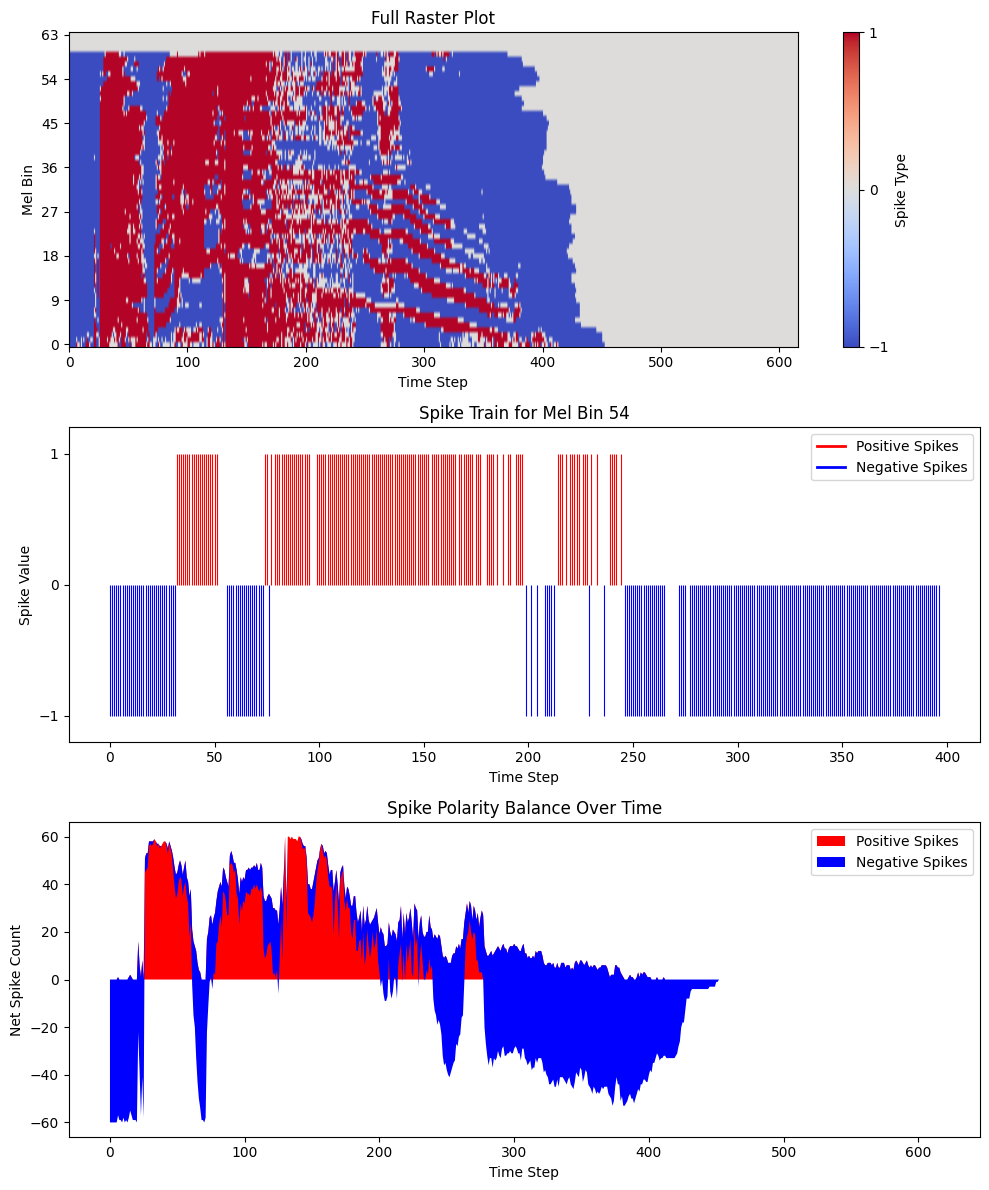

In [ ]:
visualize_spike_trains(spike_tensor=mw_x_batch, sample_idx=0, mel_bin=54)

# SNN Modelling

A single batch of data has shape: \[batch_size, time_frames, n_mels\].

In [ ]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=False,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to first hidden layer
        self.fc1 = torch.nn.Linear(n_mels, hidden_sizes[0])
        self.lif_in = snn.Leaky(
            beta=torch.rand(hidden_sizes[0]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: First hidden to second hidden layer
        self.fc2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.lif_hidden = snn.Leaky(
            beta=torch.rand(hidden_sizes[1]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output layer
        self.fc_out = torch.nn.Linear(hidden_sizes[1], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.rand(num_classes),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

    def forward(self, x):
      # Input shape: [batch_size, time_steps, n_mels]
      batch_size = x.shape[0]
      time_steps = x.shape[1]

      mem_1 = self.lif_in.init_leaky()
      mem_2 = self.lif_hidden.init_leaky()
      mem_o = self.lif_out.init_leaky()

      spk_rec = []
      mem_rec = []

      for step in range(time_steps):
        x_t = x[:, step, :]  # Shape: [batch_size, n_mels]

        cur1 = self.fc1(x_t)
        spk1, mem_1 = self.lif_in(cur1, mem_1)

        cur2 = self.fc2(spk1)
        spk2, mem_2 = self.lif_hidden(cur2, mem_2)

        cur_out = self.fc_out(spk2)
        spk_out, mem_o = self.lif_out(cur_out, mem_o)

        spk_rec.append(spk_out)
        mem_rec.append(mem_o)

      return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

## DeltaModulation Training

In [ ]:
n_mels = 64
hidden_sizes = [128, 64]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=n_mels,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=False,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 8,320
├─Leaky: 1-2                             [32, 128]                 128
├─Linear: 1-3                            [32, 64]                  8,256
├─Leaky: 1-4                             [32, 64]                  64
├─Linear: 1-5                            [32, 10]                  650
├─Leaky: 1-6                             [32, 10]                  10
Total params: 17,428
Trainable params: 17,428
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.55
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.07
Estimated Total Size (MB): 0.18

In [ ]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    Optimized training function with:
    - Optional batch limiting (for quick testing)
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [ ]:
num_epochs = 100
patience = 30
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.0001)


train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=delta_train_dataloader,
    valid_loader=delta_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Epochs:   1%|          | 1/100 [00:10<17:35, 10.66s/it]

Epoch 1/100 - 10s - loss: 11.8443 - acc: 0.1402 - val_loss: 8.3234 - val_acc: 0.0469



Epochs:   2%|▏         | 2/100 [00:20<16:12,  9.93s/it]

Epoch 2/100 - 9s - loss: 6.5980 - acc: 0.2067 - val_loss: 6.1722 - val_acc: 0.1652



Epochs:   3%|▎         | 3/100 [00:30<16:35, 10.27s/it]

Epoch 3/100 - 10s - loss: 3.7485 - acc: 0.2199 - val_loss: 3.0724 - val_acc: 0.2165



Epochs:   4%|▍         | 4/100 [00:41<16:48, 10.51s/it]

Epoch 4/100 - 10s - loss: 2.1831 - acc: 0.2725 - val_loss: 2.4268 - val_acc: 0.1830



Epochs:   5%|▌         | 5/100 [00:50<15:57, 10.08s/it]

Epoch 5/100 - 9s - loss: 2.0183 - acc: 0.2962 - val_loss: 2.5265 - val_acc: 0.2210



Epochs:   6%|▌         | 6/100 [01:01<16:10, 10.33s/it]

Epoch 6/100 - 10s - loss: 1.8872 - acc: 0.3279 - val_loss: 2.5041 - val_acc: 0.2656



Epochs:   7%|▋         | 7/100 [01:12<16:20, 10.55s/it]

Epoch 7/100 - 11s - loss: 1.7795 - acc: 0.3665 - val_loss: 2.1630 - val_acc: 0.2500



Epochs:   8%|▊         | 8/100 [01:22<15:54, 10.37s/it]

Epoch 8/100 - 9s - loss: 1.6687 - acc: 0.3774 - val_loss: 2.2094 - val_acc: 0.2366



Epochs:   9%|▉         | 9/100 [01:32<15:29, 10.21s/it]

Epoch 9/100 - 9s - loss: 1.6205 - acc: 0.3897 - val_loss: 2.1472 - val_acc: 0.1964



Epochs:  10%|█         | 10/100 [01:43<15:44, 10.50s/it]

Epoch 10/100 - 11s - loss: 1.5595 - acc: 0.4311 - val_loss: 2.1575 - val_acc: 0.2835



Epochs:  11%|█         | 11/100 [01:54<15:40, 10.57s/it]

Epoch 11/100 - 10s - loss: 1.5151 - acc: 0.4519 - val_loss: 2.3205 - val_acc: 0.2545



Epochs:  12%|█▏        | 12/100 [02:03<14:55, 10.17s/it]

Epoch 12/100 - 9s - loss: 1.4488 - acc: 0.4704 - val_loss: 2.0647 - val_acc: 0.3996



Epochs:  13%|█▎        | 13/100 [02:14<15:04, 10.39s/it]

Epoch 13/100 - 10s - loss: 1.3820 - acc: 0.5000 - val_loss: 2.1951 - val_acc: 0.3996



Epochs:  14%|█▍        | 14/100 [02:25<15:02, 10.49s/it]

Epoch 14/100 - 10s - loss: 1.3457 - acc: 0.5168 - val_loss: 2.2948 - val_acc: 0.3504



Epochs:  15%|█▌        | 15/100 [02:35<14:36, 10.31s/it]

Epoch 15/100 - 9s - loss: 1.3817 - acc: 0.5033 - val_loss: 2.0069 - val_acc: 0.3884



Epochs:  16%|█▌        | 16/100 [02:45<14:29, 10.35s/it]

Epoch 16/100 - 10s - loss: 1.3322 - acc: 0.5196 - val_loss: 1.9911 - val_acc: 0.3192



Epochs:  17%|█▋        | 17/100 [02:56<14:31, 10.50s/it]

Epoch 17/100 - 10s - loss: 1.2992 - acc: 0.5445 - val_loss: 1.8932 - val_acc: 0.3683



Epochs:  18%|█▊        | 18/100 [03:07<14:29, 10.60s/it]

Epoch 18/100 - 10s - loss: 1.2728 - acc: 0.5473 - val_loss: 2.1031 - val_acc: 0.3170



Epochs:  19%|█▉        | 19/100 [03:17<13:56, 10.33s/it]

Epoch 19/100 - 9s - loss: 1.2245 - acc: 0.5535 - val_loss: 2.1440 - val_acc: 0.4085



Epochs:  20%|██        | 20/100 [03:27<13:59, 10.49s/it]

Epoch 20/100 - 10s - loss: 1.1456 - acc: 0.5866 - val_loss: 2.2068 - val_acc: 0.3973



Epochs:  21%|██        | 21/100 [03:38<13:57, 10.60s/it]

Epoch 21/100 - 10s - loss: 1.1056 - acc: 0.6051 - val_loss: 2.0268 - val_acc: 0.3460



Epochs:  22%|██▏       | 22/100 [03:48<13:31, 10.40s/it]

Epoch 22/100 - 9s - loss: 1.0293 - acc: 0.6160 - val_loss: 2.1141 - val_acc: 0.4308



Epochs:  23%|██▎       | 23/100 [03:59<13:19, 10.39s/it]

Epoch 23/100 - 10s - loss: 1.0617 - acc: 0.6070 - val_loss: 2.0181 - val_acc: 0.3237



Epochs:  24%|██▍       | 24/100 [04:14<15:11, 11.99s/it]

Epoch 24/100 - 15s - loss: 1.0352 - acc: 0.6352 - val_loss: 1.8199 - val_acc: 0.4487



Epochs:  25%|██▌       | 25/100 [04:25<14:37, 11.70s/it]

Epoch 25/100 - 11s - loss: 1.0305 - acc: 0.6338 - val_loss: 1.9393 - val_acc: 0.3594



Epochs:  26%|██▌       | 26/100 [04:35<13:37, 11.05s/it]

Epoch 26/100 - 9s - loss: 0.9865 - acc: 0.6283 - val_loss: 2.0856 - val_acc: 0.4107



Epochs:  27%|██▋       | 27/100 [04:46<13:26, 11.04s/it]

Epoch 27/100 - 11s - loss: 0.9114 - acc: 0.6548 - val_loss: 1.9017 - val_acc: 0.4286



Epochs:  28%|██▊       | 28/100 [04:57<13:15, 11.05s/it]

Epoch 28/100 - 11s - loss: 0.8731 - acc: 0.6771 - val_loss: 2.0250 - val_acc: 0.4308



Epochs:  29%|██▉       | 29/100 [05:07<12:46, 10.79s/it]

Epoch 29/100 - 10s - loss: 0.8652 - acc: 0.6780 - val_loss: 1.5608 - val_acc: 0.4777



Epochs:  30%|███       | 30/100 [05:18<12:28, 10.70s/it]

Epoch 30/100 - 10s - loss: 0.8528 - acc: 0.6866 - val_loss: 1.6308 - val_acc: 0.4621



Epochs:  31%|███       | 31/100 [05:30<12:52, 11.19s/it]

Epoch 31/100 - 12s - loss: 0.8454 - acc: 0.6982 - val_loss: 1.8043 - val_acc: 0.4263



Epochs:  32%|███▏      | 32/100 [05:41<12:41, 11.19s/it]

Epoch 32/100 - 11s - loss: 0.8513 - acc: 0.6882 - val_loss: 1.9731 - val_acc: 0.4286



Epochs:  33%|███▎      | 33/100 [05:51<12:07, 10.86s/it]

Epoch 33/100 - 10s - loss: 0.8133 - acc: 0.7093 - val_loss: 1.8774 - val_acc: 0.4442



Epochs:  34%|███▍      | 34/100 [06:02<11:47, 10.73s/it]

Epoch 34/100 - 10s - loss: 0.7849 - acc: 0.7069 - val_loss: 1.8382 - val_acc: 0.5290



Epochs:  35%|███▌      | 35/100 [06:13<11:49, 10.91s/it]

Epoch 35/100 - 11s - loss: 0.7843 - acc: 0.7057 - val_loss: 1.9254 - val_acc: 0.4464



Epochs:  36%|███▌      | 36/100 [06:24<11:39, 10.94s/it]

Epoch 36/100 - 11s - loss: 0.7617 - acc: 0.7365 - val_loss: 2.0793 - val_acc: 0.4085



Epochs:  37%|███▋      | 37/100 [06:34<11:03, 10.53s/it]

Epoch 37/100 - 9s - loss: 0.7835 - acc: 0.7204 - val_loss: 2.1125 - val_acc: 0.4263



Epochs:  38%|███▊      | 38/100 [06:45<11:04, 10.72s/it]

Epoch 38/100 - 11s - loss: 0.7252 - acc: 0.7370 - val_loss: 1.7768 - val_acc: 0.4643



Epochs:  39%|███▉      | 39/100 [06:56<11:02, 10.87s/it]

Epoch 39/100 - 11s - loss: 0.7402 - acc: 0.7337 - val_loss: 2.1463 - val_acc: 0.4420



Epochs:  40%|████      | 40/100 [07:07<10:47, 10.79s/it]

Epoch 40/100 - 10s - loss: 0.6965 - acc: 0.7367 - val_loss: 2.3557 - val_acc: 0.3951



Epochs:  41%|████      | 41/100 [07:17<10:25, 10.60s/it]

Epoch 41/100 - 10s - loss: 0.7448 - acc: 0.7365 - val_loss: 2.5004 - val_acc: 0.3795



Epochs:  42%|████▏     | 42/100 [07:29<10:39, 11.03s/it]

Epoch 42/100 - 12s - loss: 0.6779 - acc: 0.7543 - val_loss: 2.3744 - val_acc: 0.4464



Epochs:  43%|████▎     | 43/100 [07:40<10:32, 11.10s/it]

Epoch 43/100 - 11s - loss: 0.7009 - acc: 0.7521 - val_loss: 1.6444 - val_acc: 0.5290



Epochs:  44%|████▍     | 44/100 [07:51<10:12, 10.95s/it]

Epoch 44/100 - 10s - loss: 0.6653 - acc: 0.7661 - val_loss: 2.1929 - val_acc: 0.3638



Epochs:  45%|████▌     | 45/100 [08:01<09:48, 10.70s/it]

Epoch 45/100 - 10s - loss: 0.6275 - acc: 0.7706 - val_loss: 2.0146 - val_acc: 0.4621



Epochs:  46%|████▌     | 46/100 [08:12<09:45, 10.85s/it]

Epoch 46/100 - 11s - loss: 0.6009 - acc: 0.7585 - val_loss: 2.0723 - val_acc: 0.3594



Epochs:  47%|████▋     | 47/100 [08:23<09:42, 10.99s/it]

Epoch 47/100 - 11s - loss: 0.6068 - acc: 0.7758 - val_loss: 2.1400 - val_acc: 0.3929



Epochs:  48%|████▊     | 48/100 [08:34<09:20, 10.79s/it]

Epoch 48/100 - 10s - loss: 0.6062 - acc: 0.7756 - val_loss: 1.9339 - val_acc: 0.4442



Epochs:  49%|████▉     | 49/100 [08:44<09:08, 10.76s/it]

Epoch 49/100 - 10s - loss: 0.5728 - acc: 0.7891 - val_loss: 1.9842 - val_acc: 0.3906



Epochs:  50%|█████     | 50/100 [08:56<09:06, 10.94s/it]

Epoch 50/100 - 11s - loss: 0.5711 - acc: 0.7831 - val_loss: 2.0865 - val_acc: 0.4397



Epochs:  51%|█████     | 51/100 [09:07<08:58, 10.99s/it]

Epoch 51/100 - 11s - loss: 0.5466 - acc: 0.7947 - val_loss: 2.4672 - val_acc: 0.3772



Epochs:  52%|█████▏    | 52/100 [09:17<08:32, 10.67s/it]

Epoch 52/100 - 9s - loss: 0.5629 - acc: 0.7969 - val_loss: 1.9633 - val_acc: 0.5915



Epochs:  53%|█████▎    | 53/100 [09:28<08:28, 10.81s/it]

Epoch 53/100 - 11s - loss: 0.5170 - acc: 0.8120 - val_loss: 1.9424 - val_acc: 0.5424



Epochs:  54%|█████▍    | 54/100 [09:39<08:25, 10.98s/it]

Epoch 54/100 - 11s - loss: 0.5137 - acc: 0.8089 - val_loss: 2.0302 - val_acc: 0.4464



Epochs:  55%|█████▌    | 55/100 [09:50<08:15, 11.01s/it]

Epoch 55/100 - 11s - loss: 0.4857 - acc: 0.8149 - val_loss: 1.9464 - val_acc: 0.4777



Epochs:  56%|█████▌    | 56/100 [10:00<07:47, 10.63s/it]

Epoch 56/100 - 9s - loss: 0.5211 - acc: 0.8120 - val_loss: 1.9076 - val_acc: 0.5290



Epochs:  57%|█████▋    | 57/100 [10:11<07:44, 10.80s/it]

Epoch 57/100 - 11s - loss: 0.4767 - acc: 0.8203 - val_loss: 1.9297 - val_acc: 0.5089



Epochs:  58%|█████▊    | 58/100 [10:23<07:40, 10.97s/it]

Epoch 58/100 - 11s - loss: 0.4804 - acc: 0.8250 - val_loss: 2.2189 - val_acc: 0.4933



Epochs:  58%|█████▊    | 58/100 [10:33<07:38, 10.92s/it]

Early stopping triggered


In [ ]:
print(train_loss[-1], train_acc[-1] * 100, val_loss[-1], val_acc[-1] * 100)

0.48244497721845453 82.74147727272727 2.2062246799468994 39.95535714285714


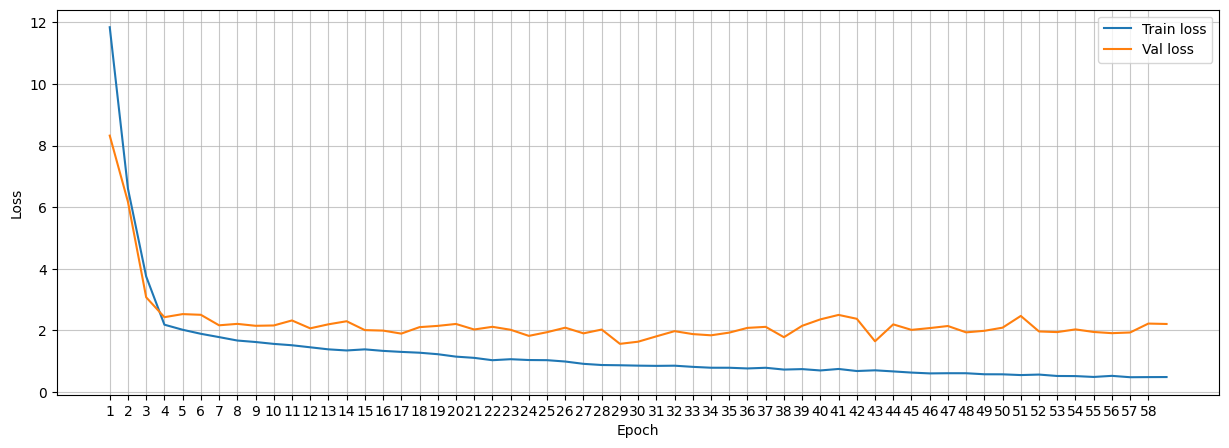

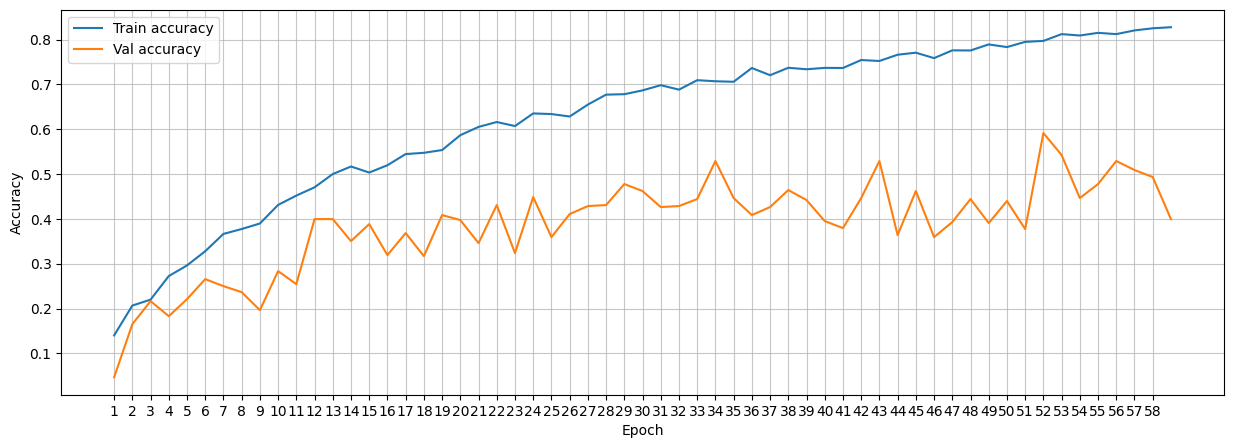

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

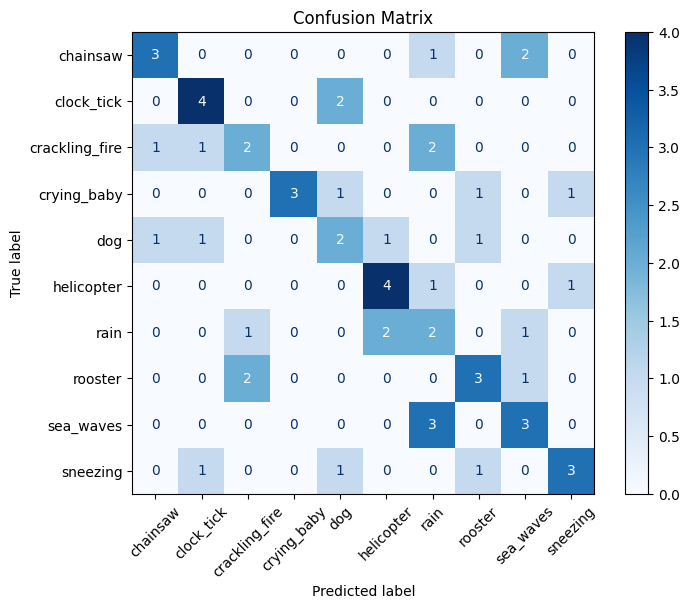

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            spk_out, _ = model(X.float())
            spk_sum = spk_out.sum(dim=0)  # shape: [batch_size, num_classes]
            preds = torch.argmax(spk_sum, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

evaluate_and_plot_confusion_matrix(snn_classifier, delta_test_dataloader, class_names)

## Moving Window Training

In [ ]:
patience = 40
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=mw_train_dataloader,
    valid_loader=mw_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

NameError: name 'snn_classifier' is not defined

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
evaluate_and_plot_confusion_matrix(snn_classifier, mw_test_dataloader, class_names)